### In this notebook we use tensorflow CNN model to find waldo.

In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

from img_gen import create_sample
import cv2

In [2]:
#constants
IMG_SIZE = 64

In [3]:
# creating waldo images

# create_sample(IMG_SIZE,5000)

In [4]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    '../data/selfmade',
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32)

print(test_ds.class_names)

Found 9354 files belonging to 2 classes.
Using 7484 files for training.
Using 1870 files for validation.
['notwaldo', 'waldo']


In [5]:
src1_ds = tf.keras.utils.image_dataset_from_directory(
    '../data/src1/64',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32)


Found 5376 files belonging to 2 classes.


In [6]:
# change src1_ds to arrays of x and y, y should be [[1.],[0.]] for waldo and [[0.],[1.]] for not waldo


src1_x = np.zeros((5376,3,64,64))
src1_y = np.zeros((5376,2,1))

for i, (images, labels) in enumerate(src1_ds):
    images = images.numpy().transpose(0,3,1,2)
    for j in range(32):
        # replace dimensions in images to 3x64x64
        src1_x[i*32+j] = images[j]
        src1_y[i*32+j] = [labels[j]]

print(src1_x.shape, src1_y.shape)

2024-06-11 23:13:08.508572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5376]
	 [[{{node Placeholder/_4}}]]
2024-06-11 23:13:08.508784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5376]
	 [[{{node Placeholder/_4}}]]
2024-06-11 23:13:08.513897: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(5376, 3, 64, 64) (5376, 2, 1)


In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Resizing
from tensorflow.keras.models import Sequential

from cnn import NeuralNetwork
from layers import ConvLayer, MaxPoolLayer, FlattenLayer, DenseLayer

def get_conv(input_shape=(IMG_SIZE, IMG_SIZE, 3), filename=None):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_my_cnn(input_shape=(3,IMG_SIZE,IMG_SIZE)):
    model = NeuralNetwork()
    model.add(ConvLayer(32, 3, input_shape=input_shape, activation='relu'))
    model.add(MaxPoolLayer((32, 62,62), (2, 2)))
    model.add(ConvLayer(64, 3,(32, 31, 31), activation='relu'))
    model.add(MaxPoolLayer((64, 29, 29), (2, 2)))
    model.add(ConvLayer(64, 3, (64, 14, 14), activation='relu'))
    model.add(MaxPoolLayer((64, 12, 12), (2, 2)))
    model.add(FlattenLayer((64, 6, 6)))
    model.add(DenseLayer((2304,), 1024, activation='relu'))
    model.add(DenseLayer((1024,), 2, activation='sigmoid'))
    
    return model

In [8]:
from tensorflow.keras.applications import ResNet50

model = get_conv()

model.summary()

model2 = get_my_cnn()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [9]:
from collections import Counter

label_counter = Counter()

# Iterate through the dataset
for images, labels in test_ds:
    # Convert the labels to numpy array if they are in tensor format
    labels_np = labels.numpy()
    
    # Update the counter with the labels in the current batch
    label_counter.update(labels_np)

# Print the number of elements for each class
for label, count in label_counter.items():
    print(f"Class {label}: {count} elements")

Class 0: 1104 elements
Class 1: 766 elements


2024-06-11 23:13:09.467750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1870]
	 [[{{node Placeholder/_4}}]]
2024-06-11 23:13:09.467918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1870]
	 [[{{node Placeholder/_4}}]]


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# both = yesset.concatenate(train_ds)
model2.train(
    src1_x,
    src1_y,
    epochs=50,
    learning_rate=0.01,
    batch_size=32,
    optimizer='grad_descent',
)

history = model.fit(train_ds, validation_data=test_ds, epochs=5)
# history2 = model2.fit(train_ds, validation_data=test_ds, epochs=10)

100%|██████████| 168/168 [39:09<00:00, 13.98s/it]


Epoch 0 Error 0.06501116071428571


100%|██████████| 168/168 [1:02:17<00:00, 22.25s/it]


Epoch 1 Error 0.06501116071428571


 37%|███▋      | 62/168 [14:44<25:12, 14.27s/it]


KeyboardInterrupt: 

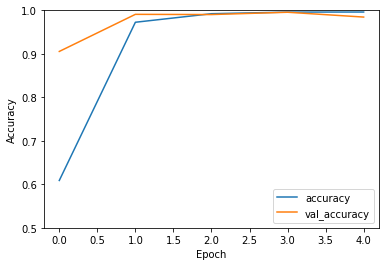

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [ ]:

test_loss, test_acc = model.evaluate(yesset, verbose=2)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

predictions = model.predict(test_ds)

print(predictions[1])

325/325 - 4s - 13ms/step - accuracy: 0.9862 - loss: 0.0471
65/65 - 1s - 12ms/step - accuracy: 0.9846 - loss: 0.0575
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[3.0777485e-16 9.9999994e-01]


In [ ]:
import os
directory_path = f'../data/selfmade/'
pref = "3_"
filenames = [(f,'waldo') for f in os.listdir(directory_path+'/waldo') if f.startswith(pref)]+[(f, 'notwaldo') for f in os.listdir(directory_path+'/notwaldo') if f.startswith(pref)]
filenames.sort()
filenames

[('3_0_0.jpg', 'notwaldo'),
 ('3_0_1.jpg', 'notwaldo'),
 ('3_0_10.jpg', 'notwaldo'),
 ('3_0_11.jpg', 'notwaldo'),
 ('3_0_12.jpg', 'notwaldo'),
 ('3_0_13.jpg', 'notwaldo'),
 ('3_0_14.jpg', 'notwaldo'),
 ('3_0_15.jpg', 'notwaldo'),
 ('3_0_2.jpg', 'notwaldo'),
 ('3_0_3.jpg', 'notwaldo'),
 ('3_0_4.jpg', 'notwaldo'),
 ('3_0_5.jpg', 'notwaldo'),
 ('3_0_6.jpg', 'notwaldo'),
 ('3_0_7.jpg', 'notwaldo'),
 ('3_0_8.jpg', 'notwaldo'),
 ('3_0_9.jpg', 'notwaldo'),
 ('3_10_0.jpg', 'notwaldo'),
 ('3_10_1.jpg', 'notwaldo'),
 ('3_10_10.jpg', 'notwaldo'),
 ('3_10_11.jpg', 'notwaldo'),
 ('3_10_12.jpg', 'notwaldo'),
 ('3_10_13.jpg', 'notwaldo'),
 ('3_10_14.jpg', 'notwaldo'),
 ('3_10_15.jpg', 'notwaldo'),
 ('3_10_2.jpg', 'notwaldo'),
 ('3_10_3.jpg', 'notwaldo'),
 ('3_10_4.jpg', 'notwaldo'),
 ('3_10_5.jpg', 'notwaldo'),
 ('3_10_6.jpg', 'notwaldo'),
 ('3_10_7.jpg', 'notwaldo'),
 ('3_10_8.jpg', 'notwaldo'),
 ('3_10_9.jpg', 'notwaldo'),
 ('3_11_0.jpg', 'notwaldo'),
 ('3_11_1.jpg', 'notwaldo'),
 ('3_11_10.jpg', '

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tqdm import tqdm

correct=0
incorrect=0
incorrect_files=[]
correct_files=[]
# print(filenames)
for fname, true in tqdm(filenames):
    img = image.load_img(f'../data/src1/{IMG_SIZE}/{true}/{fname}', target_size=(IMG_SIZE, IMG_SIZE, 3))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    # img_array /= 255.0  # Normalize the image to match the training data
    
    # Predict the class
    prediction = model.predict(img_array, verbose =0)
    predicted_class = 'waldo' if prediction[0][0] < prediction[0][1] else 'notwaldo'
    # if true == 'notwaldo':
        # print(true, prediction)
    
    # Print the prediction
    if predicted_class==true:
        correct += 1
        correct_files+=[f'../data/src1/{IMG_SIZE}/{true}/{fname}']
    else:
        incorrect_files+=[f'../data/src1/{IMG_SIZE}/{true}/{fname}']
        incorrect += 1
    # print(f'Predi,cted class: {predicted_class} with {prediction[0]}\t{"CORRECT" if predicted_class == True else "INCORRECT"}')
    
    # Optionally, display the image
    # plt.imshow(img)
    # plt.title(f'Predicted: {predicted_class}')
    # plt.show()
print(correct, incorrect)


100%|██████████| 256/256 [00:10<00:00, 24.97it/s]

252 4


In [ ]:
print(incorrect_files)

['../data/src1/64/notwaldo/3_0_14.jpg', '../data/src1/64/notwaldo/3_1_4.jpg', '../data/src1/64/notwaldo/3_2_1.jpg', '../data/src1/64/notwaldo/3_6_5.jpg']


In [ ]:
counter =0
for f in correct_files:
    if f.startswith(f'../data/src1/{IMG_SIZE}/waldo'):
        counter+=1
counter2 =0
for f in incorrect_files:
    if f.startswith(f'../data/src1/{IMG_SIZE}/waldo'):
        counter2+=1 

print("Waldo correct: ",counter, " incorrect: ", counter2)

counter =0
for f in correct_files:
    if f.startswith(f'../data/src1/{IMG_SIZE}/notwaldo'):
        counter+=1
counter2 =0
for f in incorrect_files:
    if f.startswith(f'../data/src1/{IMG_SIZE}/notwaldo'):
        counter2+=1 

print("Notwaldo correct: ",counter, " incorrect: ", counter2) 

Waldo correct:  1  incorrect:  1
Notwaldo correct:  244  incorrect:  10


In [ ]:
# ds = train_ds
# true_labels = np.concatenate([y for x, y in ds], axis=0)
# predictions = model.predict(ds)
# predictions = np.argmax(predictions, axis=1)
# counter=0
# for true, pred in zip(true_labels, predictions):
#     if true==pred:
#         counter+=1
#     # print(f"True: {true}, Predicted: {pred}")
# print(counter/len(true_labels))

 14/260 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step

2024-06-09 15:29:02.593169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
0.4980122876761836


In [ ]:
# Unbatch and batch the dataset to get all data at once
# train_images, train_labels = next(iter(src1_ds.unbatch().batch(len(train_ds))))
train_images, train_labels = zip(*[(image.numpy(), label.numpy()) for image, label in src1_ds.unbatch()])
train_images = np.array(train_images)
train_labels = np.array(train_labels)
# test_images, test_labels = next(iter(yesset.unbatch().batch(len(test_ds))))

# Predict on the training data
train_predictions = model.predict(train_images)
train_predicted_labels = tf.argmax(train_predictions, axis=1)
print(np.where(train_predicted_labels == 1)[0].shape, np.where(train_predicted_labels == 1))
print(np.where(train_labels == 1)[0].shape, np.where(train_labels == 1))
# Ensure the labels are of the same type
train_predicted_labels = tf.cast(train_predicted_labels, tf.int32)

# Calculate the number of correct predictions
correct_predictions = tf.reduce_sum(tf.cast(train_predicted_labels == train_labels, tf.int32))

# Calculate accuracy
accuracy = correct_predictions / len(train_labels)

print(f"Manual checking accuracy on training data: {accuracy * 100:.2f}%")

2024-06-09 15:41:40.043246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
(126,) (array([  13,   21,  141,  212,  254,  268,  310,  316,  435,  441,  475,
        614,  660,  724,  793,  809,  905,  940,  948,  994, 1026, 1030,
       1047, 1118, 1119, 1146, 1173, 1248, 1267, 1306, 1370, 1412, 1437,
       1548, 1562, 1591, 1606, 1611, 1665, 1750, 1791, 1864, 1883, 1969,
       1988, 2010, 2059, 2071, 2095, 2126, 2164, 2194, 2294, 2369, 2375,
       2406, 2445, 2638, 2640, 2708, 2730, 2741, 2757, 2801, 2869, 2876,
       2922, 2981, 3075, 3137, 3145, 3155, 3161, 3182, 3183, 3184, 3202,
       3282, 3305, 3307, 3319, 3352, 3402, 3452, 3578, 3584, 3622, 3653,
       3734, 3754, 3758, 3833, 3865, 3907, 3916, 3997, 4022, 4132, 4164,
       4184, 4188, 4198, 4221, 4395, 4396, 4398, 4419, 4562, 4581, 4584,
       4613, 4706, 4731, 4830, 4888, 4921, 4970, 4999, 5003, 5037, 5039,
       5125, 5148, 5154, 5251, 5314]),)
(39,) (array([ 125,  284,  370,  391,  646,  794,  874,  971,  994, 1001, 1002,
       1018, 1026, 1146, 14

In [ ]:
model.save('super_good_model.keras')